In [1]:
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
import gc
#%cd /kaggle/input/champs-scalar-coupling
#print(os.listdir("."))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


## First grab the data.
I don't like to clutter up my solution notebooks with my EDA work.  That's usually a separate notebook.

In [3]:
df_train =pd.read_csv('../input/train.csv')
df_test  =pd.read_csv('../input/test.csv')
df_struct=pd.read_csv('../input/structures.csv')

df_train_sub_charge=pd.read_csv('../input/mulliken_charges.csv')
df_train_sub_tensor=pd.read_csv('../input/magnetic_shielding_tensors.csv')

## Reduce the Memory Usage
Without this call, this kernel definitely can't be run on smaller cloud instances... I always test solutions on CoLaboratory to see if low-resource nodes can process them.  In this case, CoLab can't unless you reduce down.  The results seem similar to when the same network is trained on the full dataset.

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_struct = reduce_mem_usage(df_struct)
df_train_sub_charge = reduce_mem_usage(df_train_sub_charge)
df_train_sub_tensor = reduce_mem_usage(df_train_sub_tensor)
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)

(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)
Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)


## Map data into a master dataframe
Here's the code to do mappings.  The drop_duplicates is important, else your test dataset will grow and your predictions will not be output correctly.

In [6]:
''' 
Map atom info from the structures.csv into the train/test files
'''
import psutil
import os

def map_atom_info(df_1,df_2, atom_idx):
    print('Mapping...', df_1.shape, df_2.shape, atom_idx)
    
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)

    return df

def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

show_ram_usage()

for atom_idx in [0,1]:
    df_train = map_atom_info(df_train,df_struct, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_charge, atom_idx)
    df_train = map_atom_info(df_train,df_train_sub_tensor, atom_idx)
    df_train = df_train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'mulliken_charge': f'charge_{atom_idx}',
                                        'XX': f'XX_{atom_idx}',
                                        'YX': f'YX_{atom_idx}',
                                        'ZX': f'ZX_{atom_idx}',
                                        'XY': f'XY_{atom_idx}',
                                        'YY': f'YY_{atom_idx}',
                                        'ZY': f'ZY_{atom_idx}',
                                        'XZ': f'XZ_{atom_idx}',
                                        'YZ': f'YZ_{atom_idx}',
                                        'ZZ': f'ZZ_{atom_idx}',})
    df_test = map_atom_info(df_test,df_struct, atom_idx)
    df_test = df_test.rename(columns={'atom': f'atom_{atom_idx}',
                                'x': f'x_{atom_idx}',
                                'y': f'y_{atom_idx}',
                                'z': f'z_{atom_idx}'})
    #add some features
    
    df_struct['c_x']=df_struct.groupby('molecule_name')['x'].transform('mean')
    df_struct['c_y']=df_struct.groupby('molecule_name')['y'].transform('mean')
    df_struct['c_z']=df_struct.groupby('molecule_name')['z'].transform('mean')
    df_struct['atom_n']=df_struct.groupby('molecule_name')['atom_index'].transform('max')
    
    show_ram_usage()
    print(df_train.shape, df_test.shape)

RAM usage: 0.7256965637207031 GB
Mapping... (4658147, 6) (2358657, 6) 0
Mapping... (4658147, 10) (1533537, 3) 0
Mapping... (4658147, 11) (1533537, 11) 0
Mapping... (2505542, 5) (2358657, 6) 0
RAM usage: 1.3466949462890625 GB
(4658147, 20) (2505542, 9)
Mapping... (4658147, 20) (2358657, 10) 1
Mapping... (4658147, 28) (1533537, 3) 1
Mapping... (4658147, 29) (1533537, 11) 1
Mapping... (2505542, 9) (2358657, 10) 1
RAM usage: 1.4347801208496094 GB
(4658147, 38) (2505542, 17)


## Start developing more complex features

In [7]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df

df_train=make_features(df_train)
df_test=make_features(df_test) 
#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)
test_prediction=np.zeros(len(df_test))
show_ram_usage()
print(df_train.shape, df_test.shape)

def get_dist(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all=pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('max')
    
    df_temp= df_temp_all[df_temp_all["min_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'distance': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["distance"]].copy()
    df_temp=df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'distance': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df
df_test=(get_dist(df_test))    
df_train=(get_dist(df_train)) 

print(df_train.shape, df_test.shape)
show_ram_usage()

RAM usage: 1.4354248046875 GB
(4658147, 42) (2505542, 21)
Mapping... (2505542, 21) (790486, 8) 0
Mapping... (2505542, 27) (790486, 8) 1
Mapping... (2505542, 33) (775149, 8) 0
Mapping... (2505542, 39) (775149, 8) 1
Mapping... (4658147, 42) (1468792, 8) 0
Mapping... (4658147, 48) (1468792, 8) 1
Mapping... (4658147, 54) (1440019, 8) 0
Mapping... (4658147, 60) (1440019, 8) 1
(4658147, 66) (2505542, 45)
RAM usage: 2.038860321044922 GB


## Here is where the Cosine Distance features are Created

In [8]:
def add_features(df):
    df["distance_center0"]=((df['x_0']-df['c_x'])**2+(df['y_0']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["distance_center1"]=((df['x_1']-df['c_x'])**2+(df['y_1']-df['c_y'])**2+(df['z_0']-df['c_z'])**2)**(1/2)
    df["distance_c0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_c1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["distance_f0"]=((df['x_0']-df['x_farthest_0'])**2+(df['y_0']-df['y_farthest_0'])**2+(df['z_0']-df['z_farthest_0'])**2)**(1/2)
    df["distance_f1"]=((df['x_1']-df['x_farthest_1'])**2+(df['y_1']-df['y_farthest_1'])**2+(df['z_1']-df['z_farthest_1'])**2)**(1/2)
    df["vec_center0_x"]=(df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    df["vec_center0_y"]=(df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    df["vec_center0_z"]=(df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    df["vec_center1_x"]=(df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    df["vec_center1_y"]=(df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    df["vec_center1_z"]=(df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    df["vec_c0_x"]=(df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_y"]=(df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c0_z"]=(df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    df["vec_c1_x"]=(df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_y"]=(df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_c1_z"]=(df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    df["vec_f0_x"]=(df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_y"]=(df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f0_z"]=(df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    df["vec_f1_x"]=(df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_y"]=(df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_f1_z"]=(df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_c0_c1"]=df["vec_c0_x"]*df["vec_c1_x"]+df["vec_c0_y"]*df["vec_c1_y"]+df["vec_c0_z"]*df["vec_c1_z"]
    df["cos_f0_f1"]=df["vec_f0_x"]*df["vec_f1_x"]+df["vec_f0_y"]*df["vec_f1_y"]+df["vec_f0_z"]*df["vec_f1_z"]
    df["cos_center0_center1"]=df["vec_center0_x"]*df["vec_center1_x"]+df["vec_center0_y"]*df["vec_center1_y"]+df["vec_center0_z"]*df["vec_center1_z"]
    df["cos_c0"]=df["vec_c0_x"]*df["vec_x"]+df["vec_c0_y"]*df["vec_y"]+df["vec_c0_z"]*df["vec_z"]
    df["cos_c1"]=df["vec_c1_x"]*df["vec_x"]+df["vec_c1_y"]*df["vec_y"]+df["vec_c1_z"]*df["vec_z"]
    df["cos_f0"]=df["vec_f0_x"]*df["vec_x"]+df["vec_f0_y"]*df["vec_y"]+df["vec_f0_z"]*df["vec_z"]
    df["cos_f1"]=df["vec_f1_x"]*df["vec_x"]+df["vec_f1_y"]*df["vec_y"]+df["vec_f1_z"]*df["vec_z"]
    df["cos_center0"]=df["vec_center0_x"]*df["vec_x"]+df["vec_center0_y"]*df["vec_y"]+df["vec_center0_z"]*df["vec_z"]
    df["cos_center1"]=df["vec_center1_x"]*df["vec_x"]+df["vec_center1_y"]*df["vec_y"]+df["vec_center1_z"]*df["vec_z"]
    df=df.drop(['vec_c0_x','vec_c0_y','vec_c0_z','vec_c1_x','vec_c1_y','vec_c1_z',
                'vec_f0_x','vec_f0_y','vec_f0_z','vec_f1_x','vec_f1_y','vec_f1_z',
                'vec_center0_x','vec_center0_y','vec_center0_z','vec_center1_x','vec_center1_y','vec_center1_z',
                'vec_x','vec_y','vec_z'], axis=1)
    return df
    
df_train=add_features(df_train)
df_test=add_features(df_test)
print(df_train.shape, df_test.shape)
show_ram_usage()

(4658147, 81) (2505542, 60)
RAM usage: 2.0719871520996094 GB


## Here you add the external extra features

In [9]:
case = '1JHC'

In [11]:
FE021_train_1JHC = pd.read_parquet('../data/FE021/FE021-train-1JHC.parquet', engine='pyarrow')
FE021_test_1JHC = pd.read_parquet('../data/FE021/FE021-test-1JHC.parquet', engine='pyarrow')

FE021_train_1JHN = pd.read_parquet('../data/FE021/FE021-train-1JHN.parquet', engine='pyarrow')
FE021_test_1JHN = pd.read_parquet('../data/FE021/FE021-test-1JHN.parquet', engine='pyarrow')

FE021_train_2JHH = pd.read_parquet('../data/FE021/FE021-train-2JHH.parquet', engine='pyarrow')
FE021_test_2JHH = pd.read_parquet('../data/FE021/FE021-test-2JHH.parquet', engine='pyarrow')

FE021_train_2JHC = pd.read_parquet('../data/FE021/FE021-train-2JHC.parquet', engine='pyarrow')
FE021_test_2JHC = pd.read_parquet('../data/FE021/FE021-test-2JHC.parquet', engine='pyarrow')

FE021_train_2JHN = pd.read_parquet('../data/FE021/FE021-train-2JHN.parquet', engine='pyarrow')
FE021_test_2JHN = pd.read_parquet('../data/FE021/FE021-test-2JHN.parquet', engine='pyarrow')

FE021_train_3JHH = pd.read_parquet('../data/FE021/FE021-train-3JHH.parquet', engine='pyarrow')
FE021_test_3JHH = pd.read_parquet('../data/FE021/FE021-test-3JHH.parquet', engine='pyarrow')

FE021_train_3JHC = pd.read_parquet('../data/FE021/FE021-train-3JHC.parquet', engine='pyarrow')
FE021_test_3JHC = pd.read_parquet('../data/FE021/FE021-test-3JHC.parquet', engine='pyarrow')

FE021_train_3JHN = pd.read_parquet('../data/FE021/FE021-train-3JHN.parquet', engine='pyarrow')
FE021_test_3JHN = pd.read_parquet('../data/FE021/FE021-test-3JHN.parquet', engine='pyarrow')


In [9]:

#train_raw_type = train_raw.loc[train_raw['type'] == bond_type].reset_index(drop=True)
#train_df = pd.concat([train_raw_type, train_df], axis=1)

In [10]:
# train6.drop( ['id','typei'], inplace=True, axis=1 )
# test6.drop(  ['id','typei'], inplace=True, axis=1 )
# train6.head()

In [12]:
df_train.sort_values('id', inplace=True)
df_test.sort_values( 'id', inplace=True)
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,distance_f1,cos_c0_c1,cos_f0_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,...,1.091797,-1.000000,-0.816406,0.000145,-1.000000,1.000000,-0.816406,1.000000,-1.000000,-0.000144
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.783203,-0.333496,-0.500488,-0.333496,-0.816406,0.817383,-1.000000,0.500488,-0.816406,0.817383
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.783203,-0.333252,-0.000041,-0.567871,-0.816406,0.816895,-0.499756,0.500488,-0.816895,1.392578
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,...,1.783203,-0.333008,-0.500000,-0.585449,-0.816406,0.816406,-0.500000,0.999512,-0.816406,1.435547
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,...,1.091797,0.333496,0.000189,0.007412,-1.000977,-0.333496,-0.816895,-0.333496,-1.000977,-0.007412


In [13]:
df_train_case = df_train.loc[df_train.type==case, :].reset_index(drop=True)
df_test_case = df_test.loc[df_test.type==case, :].reset_index(drop=True)

In [14]:
len(df_train_case), len(FE021_train_1JHC), len(df_test_case)

(709416, 709416, 380609)

In [15]:
#Impute NA with mean

MEAN = pd.concat([FE021_train_1JHC,FE021_test_1JHC]).mean()
FE021_train_1JHC.fillna( value=MEAN, inplace=True )
FE021_test_1JHC.fillna( value=MEAN, inplace=True )
FE021_train_1JHC.head()

,10th_closest_to_1_valence_x_cube_inv_dist,12th_closest_to_1_valence,13th_closest_to_1_exact_mass,17th_closest_to_0_spin_multiplicity,17th_closest_to_0_valence,17th_closest_to_0_valence_x_cube_inv_dist,17th_closest_to_1_spin_multiplicity,18th_closest_to_0_exact_mass,19th_closest_to_0_spin_multiplicity,19th_closest_to_1_spin_multiplicity_x_cube_inv_dist,...,tor_ang_2leftleft_count,tor_ang_2leftleft_max,tor_ang_2leftleft_min,val_not_0_mean,val_not_1_mean,val_not_1_std,yukawa_H.x,yukawa_H.y,yukawa_N.x,yukawa_O.y
0,0.08638,1.969477,6.210087,0.001063,1.538449,0.013848,0.001074,3.800028,0.00024,0.000003,...,4.615952,125.460482,-124.658907,1.75,1.0,0.0,0.504328,1.342247,0.000000,0.0
1,0.08638,1.969477,6.210087,0.001063,1.538449,0.013848,0.001074,3.800028,0.00024,0.000003,...,4.615952,125.460482,-124.658907,1.75,1.0,0.0,0.504327,1.342247,0.000000,0.0
2,0.08638,1.969477,6.210087,0.001063,1.538449,0.013848,0.001074,3.800028,0.00024,0.000003,...,4.615952,125.460482,-124.658907,1.75,1.0,0.0,0.504323,1.342247,0.000000,0.0
3,0.08638,1.969477,6.210087,0.001063,1.538449,0.013848,0.001074,3.800028,0.00024,0.000003,...,4.615952,125.460482,-124.658907,1.75,1.0,0.0,0.504323,1.342247,0.000000,0.0
4,0.08638,1.969477,6.210087,0.001063,1.538449,0.013848,0.001074,3.800028,0.00024,0.000003,...,4.615952,125.460482,-124.658907,1.50,1.0,0.0,0.000000,0.344177,0.108789,0.0


In [17]:
# print(df_train.shape)
df_train_case_final = pd.concat( [df_train_case,FE021_train_1JHC], axis=1 )
df_test_case_final  = pd.concat( [df_test_case ,FE021_test_1JHC ], axis=1 )


In [18]:
len(df_train_case_final), len(df_test_case_final)

(709416, 380609)

In [19]:
extra_featus =  list(df_train_case_final.columns[81:])
extra_featus[:10]

['10th_closest_to_1_valence_x_cube_inv_dist',
 '12th_closest_to_1_valence',
 '13th_closest_to_1_exact_mass',
 '17th_closest_to_0_spin_multiplicity',
 '17th_closest_to_0_valence',
 '17th_closest_to_0_valence_x_cube_inv_dist',
 '17th_closest_to_1_spin_multiplicity',
 '18th_closest_to_0_exact_mass',
 '19th_closest_to_0_spin_multiplicity',
 '19th_closest_to_1_spin_multiplicity_x_cube_inv_dist']

## Neural Network definition

This neural network is many layers.  In the middle we define our outputs for our two Mullikan charges as well as our Dipole Moment.  The final output is the one we care the most about, the Scalar Coupling Constant.

I think that BatchNormalization at each layer seems superior than small amounts of dropouts.  The network seems to not overfit, even in large numbers of training epochs.  If you do wind up seeing some overfitting, then adding the dropout to a couple of layers ought to help a lot.

In [20]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(1024)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.05)(x)
#     #x = Dropout(0.4)(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.05)(x)
    #x = Dropout(0.4)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    #x = Dropout(0.4)(x)
    out1 = Dense(2, activation="linear",name='outM2')(x)#mulliken charge 2
    out2 = Dense(6, activation="linear",name='outT6')(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear",name='outT12')(x)#tensor 12(others) 
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    #x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
#     x = Dense(128)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.05)(x)
    #x = Dropout(0.2)(x)
    out = Dense(1, activation="linear",name='out')(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model

In [21]:
nn_model=create_nn_model( 10 )
nn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         11264       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024)         4096        dense_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyR

## Plot Function
I rely a lot on loss plots to detect when learning has stopped as well as when overfitting begins.

In [22]:
def plot_history(history, label):
    plt.plot(history.history['loss'][-100:])
    plt.plot(history.history['val_loss'][-100:])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [24]:
splits = df_train.id%5
len(np.where(splits==4)[0])

931629

In [25]:
len(df_train), len(df_train_)

NameError: name 'df_train_' is not defined

## Main Routine

A bunch of stuff happens here.  Pay attention to the callbacks.  I train a different model for each molecule type, which allows for future retraining.  If you have kept your network the same (except for dropout, etc.), and want to retrain for a few more epochs without having to go back to the beginning, then set the retrain flag to False and it will grab the trained models as starting points.

In [27]:
from datetime import datetime

#mol_types=df_train["type"].unique()
mol_types = ['1JHC']
cv_score=[]
cv_score_total=0 
epoch_n = 500 # 300
verbose = 2
batch_size = 1024 # 512
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = False


# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type
for mol_type in mol_types:
    model_name_rd = ('../keras-neural-net-for-champs/molecule_model_%s.hdf5' % mol_type)
    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
    df_train_ = df_train_case_final[ df_train_case_final["type"]==mol_type]
    df_test_  = df_test_case_final [ df_test_case_final["type"]==mol_type]
    splits = df_train_.id%5

    # Here's our best features.  We think.
    input_features=[
        "x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                    'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                    "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                    "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",

    ] + extra_featus

    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
    
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
    target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
    target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
    
    #following parameters should be adjusted to control the loss function
    #if all parameters are zero, attractors do not work. (-> simple neural network)
    m1=2
    m2=4
    m3=1
    target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
    target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
    target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
    
    # Simple split to provide us a validation set to do our CV checks with
    #train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.05)
    train_index = np.where(splits != 0)[0]
    cv_index = np.where(splits == 0)[0]
    
    # Split all our input and targets by train and cv indexes
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_target_1=target_data_1[train_index]
    cv_target_1=target_data_1[cv_index]
    train_target_2=target_data_2[train_index]
    cv_target_2=target_data_2[cv_index]
    train_target_3=target_data_3[train_index]
    cv_target_3=target_data_3[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    #nn_model.compile(loss='mean_squared_error', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_out_loss', min_delta=0.0005, patience=30,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=0.3333,patience=15, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_out_loss', save_best_only=True, period=1)

    print (train_input.shape, cv_input.shape)
    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
                           validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
                           callbacks=[es, rlr, sv_mod],
                           epochs=epoch_n,
                           batch_size=batch_size,
                           verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    
    accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
    print( accuracy,np.log(accuracy) )
    
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
    K.clear_session()

cv_score_total/=len(mol_types)

Training 1JHC out of ['1JHC'] 

(567515, 387) (141901, 387)
Instructions for updating:
Use tf.cast instead.
Train on 567515 samples, validate on 141901 samples
Epoch 1/500
 - 155s - loss: 64.7662 - out_loss: 62.2774 - outM2_loss: 0.2724 - outT6_loss: 1.4888 - outT12_loss: 0.7276 - val_loss: 8.0851 - val_out_loss: 5.6313 - val_outM2_loss: 0.3295 - val_outT6_loss: 1.4008 - val_outT12_loss: 0.7235
Epoch 2/500


KeyboardInterrupt: 

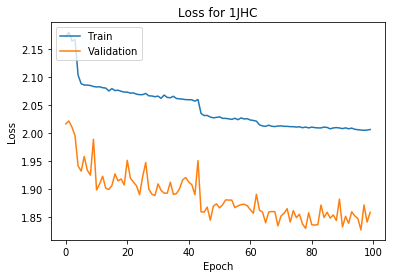

In [29]:
    plot_history(history, mol_type)


In [ ]:
test_input.shape

In [26]:
print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

Total training time:  3:43:13.005300
1JHC : cv score is  -0.8547819
total cv score is -0.8547819256782532


## Prepare results for Submission

The total CV score matches Kaggle's score pretty closely.

In [ ]:
def submit(predictions):
    submit = pd.read_csv('../input/sample_submission.csv')
    print(len(submit), len(predictions))   
    submit["scalar_coupling_constant"] = predictions
    submit.to_csv("../submissions/keras-neural-net-1.csv", index=False)
submit(test_prediction)

print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

In [ ]:
len(df_test_)

In [ ]:
mol_types=df_train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 50
verbose = 2
batch_size = 512
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True


# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type
for mol_type in mol_types:
    model_name_rd = ('../keras-neural-net-for-champs/molecule_model_%s.hdf5' % mol_type)
    model_name_wrt = ('working/molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
    df_train_ = df_train[df_train["type"]==mol_type]
    df_test_  = df_test [ df_test["type"]==mol_type]

    # Here's our best features.  We think.
    input_features=[
        "x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z",
                    'x_closest_0','y_closest_0','z_closest_0','x_closest_1','y_closest_1','z_closest_1',
                    "distance","distance_center0","distance_center1", "distance_c0","distance_c1","distance_f0","distance_f1",
                    "cos_c0_c1","cos_f0_f1","cos_center0_center1","cos_c0","cos_c1","cos_f0","cos_f1","cos_center0","cos_center1",
                    "atom_n",
                        'link0', 'dist_xyz', 'inv_dist0',
       'inv_dist1', 'inv_distP', 'inv_dist0R', 'inv_dist1R', 'inv_distPR',
       'inv_dist0E', 'linkM0', 'min_molecule_atom_0_dist_xyz',
       'mean_molecule_atom_0_dist_xyz', 'max_molecule_atom_0_dist_xyz',
       'sd_molecule_atom_0_dist_xyz', 'min_molecule_atom_1_dist_xyz',
       'mean_molecule_atom_1_dist_xyz', 'max_molecule_atom_1_dist_xyz',
       'distN0', 'distN1', 'bond_lengths_mean_y', 'bond_lengths_std_y',
       'yukawa_C.x', 'yukawa_H.x', 'yukawa_N.x', 'yukawa_O.x', 'yukawa_C.y',
       'yukawa_H.y', 'yukawa_N.y', 'yukawa_O.y', 'qm9_1', 'qm9_2', 'adH1',
       'adC1', 'adC2', 'adC3', 'adC4', 'adC5', 'adN1', 'adN2', 'F1dist1',
       'F1dist2', 'F1dist3', 'bond_atom', 'bond_distance', 'tertiary_angle_0',
       'tertiary_angle_1', 'tertiary_angle_2', 'tertiary_angle_3',
       'tertiary_angle_4', 'tertiary_angle_5', 'tertiary_angle_6',
       'tertiary_angle_7', 'tertiary_distance_0', 'tertiary_distance_1',
       'tertiary_distance_2', 'tertiary_distance_3', 'tertiary_distance_4',
       'tertiary_distance_5', 'tertiary_distance_6', 'tertiary_distance_7',
    ]

    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
    
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
    target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
    target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
    
    #following parameters should be adjusted to control the loss function
    #if all parameters are zero, attractors do not work. (-> simple neural network)
    m1=2
    m2=4
    m3=1
    target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
    target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
    target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
    
    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.05)
    
    # Split all our input and targets by train and cv indexes
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_target_1=target_data_1[train_index]
    cv_target_1=target_data_1[cv_index]
    train_target_2=target_data_2[train_index]
    cv_target_2=target_data_2[cv_index]
    train_target_3=target_data_3[train_index]
    cv_target_3=target_data_3[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    #if not retrain:
    nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam(lr=0.00001))#, metrics=[auc])
    #nn_model.compile(loss='mean_squared_error', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_out_loss', min_delta=0.0005, patience=30,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=0.3333,patience=15, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_out_loss', save_best_only=True, period=1)

    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
                           validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
                           callbacks=[es, rlr, sv_mod],
                           epochs=epoch_n,
                           batch_size=batch_size,
                           verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    
    accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
    print( accuracy,np.log(accuracy) )
    
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
    K.clear_session()

cv_score_total/=len(mol_types)



In [ ]:
len(df_test), len(test_prediction[df_test["type"]==mol_type])

In [ ]:
# 1JHC : cv score is  -0.60937184
# 2JHH : cv score is  -2.0246258
# 1JHN : cv score is  -1.3377854
# 2JHN : cv score is  -2.0205796
# 2JHC : cv score is  -1.4633688
# 3JHH : cv score is  -1.8357394
# 3JHC : cv score is  -1.4595399
# 3JHN : cv score is  -2.2611656
# total cv score is -1.6265220269560814

In [ ]:
def submit(predictions):
    submit = pd.read_csv('../input/sample_submission.csv')
    print(len(submit), len(predictions))   
    submit["scalar_coupling_constant"] = predictions
    submit.to_csv("../submissions/keras-neural-net-1-ft.csv", index=False)
submit(test_prediction)

print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)